In [1]:
## importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import chi2_contingency
from statannot import add_stat_annotation
import matplotlib.lines as lines
pd.options.mode.chained_assignment = None  # default='warn'

# Locusta migratoria and Cochliomyia hominivorax (screwworm)

This notebook needs:
- Blat results after best hit and remove redundancy (CDS_vs_genome.sortedbyDB.nonredundant)
- 1 to 1 orthologus genes of screwworm-Panorpa (Panorpa_screw_1to1.txt)
- Location of screwworm genes (cds_loc.txt)
- Panorpa transcripts assignment (X/A) (trans_location25.txt or trans_location_all.txt)


It will output:
- Plot with percentage of X-linked genes in L. migratoria and location in Panorpa genome: X in F, X not in F, Autosomes (png file)



In [2]:
## data1: creates dataframe with homologous genes within the screwworm and n. appendiculata
data1 = pd.read_table('/nfs/scistore18/vicosgrp/llayanaf/Scorpionflies/locusta/CDS_vs_genome.sortedbyDB.nonredundant', delimiter = '	', header=None)
## selects only columns 9 and 13 of data1
data = data1[[9,13]]
## gives names of columns in data
data.columns=['Transcript','Scaffold_sp']

In [3]:
## adds a collumn 'chromosome_sp' to data specifying which scaffolds in the species are X-linked or autosomal
## according to the pusblished genome in NCBI with accesion number GCA_026315105.1
data['chromosome_sp'] = data['Scaffold_sp'].apply(lambda x: 'X' if x == 'CM048755.1' else 'A')

In [4]:
## dataOrtho: creates dataframe dataOrtho with orthologous genes panorpa/screwworm file from orthofinder 'Panorpa_screw_1to1.txt'
dataOrtho = pd.read_table('/nfs/scistore18/vicosgrp/llayanaf/Scorpionflies/screwworm/Panorpa_screw_1to1.txt', header= None, delimiter=' ')
## ortho: dataframe with only column 0 and 1 from dataOrtho
ortho = dataOrtho[[0,1]]
## gives names to columns in ortho
ortho.columns = ['Transcript','trueGenes']
## creates daraframe cds_loc with screwworm location and ME assigment file 'cds_loc.txt'
cds_loc = pd.read_table('/nfs/scistore18/vicosgrp/llayanaf/Scorpionflies/screwworm/cds_loc.txt', delimiter=',')
## merges data and ortho according to 'Transcript' and cds_loc according to 'trueGenes' in tip dataframe
tip =  data.merge(ortho, on = ['Transcript']).merge(cds_loc, on = ['trueGenes'])

# Analysis with 25 largest scaffolds or all scaffolds in Panorpa genome
Select file with Panorpa transcripts assignment (X/A) 
- trans_location25.txt 
- trans_location_all.txt

In [5]:
## trans_loc: creates dataframe from panorpa transcripts location file
trans_loc = pd.read_table('/nfs/scistore18/vicosgrp/llayanaf/Scorpionflies/paper/trans_location25.txt',delimiter=',')

# Homology analysis

In [6]:
## merges trans_loc and tip according to 'Transcript' in finald dataframe
finald = trans_loc.merge(tip, on = ['Transcript'])

In [7]:
## counts of genes that are X-linked or autosomal in panorpa and in the species
## in each trueLocation "muller element'of the screwworm 
## nA: genes not assigned to muller elements
pd.crosstab(finald.trueLocation, [finald.chromosome_pan, finald.chromosome_sp],
            margins=True,margins_name='Total')

chromosome_pan     A         X      Total
chromosome_sp      A    X    A    X      
trueLocation                             
A                277   35   12   18   342
B                282   19   10   12   323
C                277   14   19   21   331
D                331   17   19   15   382
E                353   34   58   36   481
F                  9    0    4    9    22
Total           1529  119  122  111  1881

In [8]:
## how many genes do we have in each category
## xxf: X-linked genes in panorpa and the species in the element F of the screwworm
## xx: X-linked genes in panorpa and the species
## xaf: X-linked genes in panorpa, autosomal in the species in the element F of the screwworm
## xa: X-linked genes in panorpa and autosomal in the species
## ax: autosomal genes in panorpa and X-lnked in the species
## axf: autosomal genes in panorpa and X-linked in the species in the element F of the screwworm
## aa: autosomal genes in panorpa and the species
## aaf: autosomal genes in panorpa and the species and in the element F of the screwworm
xxf = len(finald['chromosome_pan'][(finald['chromosome_pan']=="X") & (finald['chromosome_sp']=="X") & (finald['trueLocation']=="F")].index)
xx = len(finald['chromosome_pan'][(finald['chromosome_pan']=="X") & (finald['chromosome_sp']=="X")].index)
xaf = len(finald['chromosome_pan'][(finald['chromosome_pan']=="X") & (finald['chromosome_sp']=="A") & (finald['trueLocation']=="F")].index)
xa = len(finald['chromosome_pan'][(finald['chromosome_pan']=="X") & (finald['chromosome_sp']=="A")].index)
ax = len(finald['chromosome_pan'][(finald['chromosome_pan']=="A") & (finald['chromosome_sp']=="X")].index)
axf = len(finald['chromosome_pan'][(finald['chromosome_pan']=="A") & (finald['chromosome_sp']=="X") & (finald['trueLocation']=="F")].index)
aa = len(finald['chromosome_pan'][(finald['chromosome_pan']=="A") & (finald['chromosome_sp']=="A")].index)
aaf = len(finald['chromosome_pan'][(finald['chromosome_pan']=="A") & (finald['chromosome_sp']=="A") & (finald['trueLocation']=="F")].index)

In [9]:
## chromosome: list of chromosomal location in panorpa
chromosome = ['X in F','X not F','Autosomes']
## frequency: list of the frequency of genes in each chromosomal location
frequency =[xxf/(xxf+xaf)*100,(xx-xxf)/((xx-xxf)+(xa-xaf))*100,ax/(ax+aa)*100]
## contingency table for each chromosomal location
## categorical values: gene type in species (X-linked or autosomal) and location (in F/not in F or autosomal)
contg1=[]
contg_xf = [[xxf,ax],[xaf,aa]]
contg1.append(contg_xf)
contg_xnf = [[(xx-xxf),ax],[(xa-xaf),aa]]
contg1.append(contg_xnf)
pvalues = []
## this is just an auxiliar list 
contg_a = [[0,0],[0,0]]
contg1.append(contg_a)
pvalues = []
## chi-squared test
for i in range(3):
    tat, p, dof, expected = chi2_contingency(contg1[i])
    pvalues.append(p)
    i = i+1
## df: final dataframe with the frequency and p-values
df = pd.DataFrame({'chromosome': chromosome, 'frequency': frequency, 'pvalues': pvalues}, columns=['chromosome', 'pvalues', 'frequency'])

/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/stats/contingency.py:134: RuntimeWarning: invalid value encountered in divide
  expected = reduce(np.multiply, margsums) / observed.sum() ** (d - 1)


In [10]:
## (for plot) conditions to assign significance according to p-values
##  p-value >= 0.05 : NS
##  p-value <= 0.001 : ***
##  p-value <= 0.01 : **
##  p-value <= 0.05 : *
## adds a new column 'significance' to dataframe df
df['significance'] = ['NS' if x >= 0.05 else '***' if x <= 0.001 
                     else '**' if x <= 0.01 else '*' if x <= 0.05 else 'ab' for x in df['pvalues']]
## converts significance labels into a list from the dataframe df
sig = df['significance'].tolist()
## shows dataframe df
df

,chromosome,pvalues,frequency,significance
0,X in F,4.932853e-15,69.230769,***
1,X not F,3.824781e-63,46.363636,***
2,Autosomes,NaN,7.220874,ab


# Figure

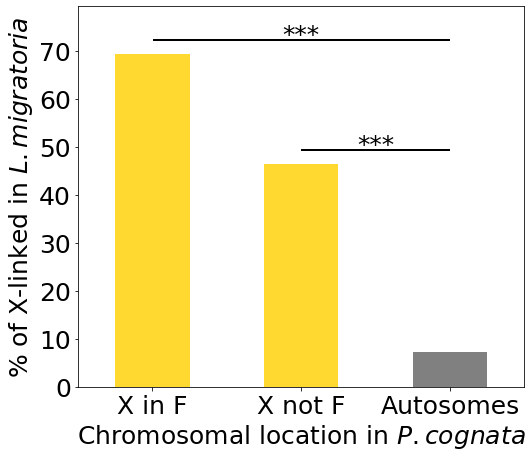

In [11]:
## fs: font size
fs = 25
## final plot
plots = df.plot.bar('chromosome','frequency',legend = False, color=['#FFD92F', '#FFD92F', 'gray'], rot = 0,figsize = (8,7), fontsize = fs)
## annotates significance labels 
plots.annotate(sig[0],xy=(1,frequency[0]+4), horizontalalignment='center',
              verticalalignment='center',fontsize = fs)
plots.annotate(sig[1],xy=(1.5,frequency[1]+4), horizontalalignment='center',
              verticalalignment='center',fontsize = fs)
## lines for statistical annotations
plots.hlines(y=frequency[0]+3, xmin=0.005, xmax=2, linewidth=2, color='black')
plots.hlines(y=frequency[1]+3, xmin=1, xmax=2, linewidth=2, color='black')
## y-axis limit
plt.ylim([0, frequency[0]+10])
## labels of x and y- axis
plt.xlabel("Chromosomal location in $\it{P. cognata}$", fontsize=fs)
plt.ylabel("% of X-linked in $\it{L. migratoria}$", fontsize=fs)
## saves figure as png
plt.savefig('/nfs/scistore18/vicosgrp/llayanaf/Scorpionflies/paper/t/25locusta.png', bbox_inches='tight',dpi=400)
## shows plot
plt.show()